In [1]:
def print_logprob(response):
 """
 Print log probabilities for each token in the response
 """
 if response.candidates and response.candidates[0].logprobs_result:
   logprobs_result = response.candidates[0].logprobs_result
   for i, chosen_candidate in enumerate(logprobs_result.chosen_candidates):
     print(
       f"Token: '{chosen_candidate.token}' ({chosen_candidate.log_probability:.4f})"
       )
     print("-" * 20)

In [ ]:
import json
import re
from loguru import logger
from google import genai
from google.genai import types as genTypes
from PIL import Image

from vif.models.detection import SegmentationMask
from vif.prompts.identification_prompts import SEGMENTATION_PROMPT
from vif.utils.detection_utils import parse_segmentation_masks
from vif.utils.image_utils import encode_image


2025-10-07 14:40:03.580 | INFO     | vif.utils.caching:instantiate_cache:26 - seg_cache cache loaded


In [ ]:
import math


def get_mask_seg_logbprob(response):
    """
    Print log probabilities for each token in the response
    """
    
    probs = []
    if response.candidates and response.candidates[0].logprobs_result:
        logprobs_result = response.candidates[0].logprobs_result
        i = 0
        while i< len(logprobs_result.chosen_candidates):
            chosen_candidate = logprobs_result.chosen_candidates[i]
            if "{" in chosen_candidate.token :
                current_detection = {}
                i+=1
                current_string =""
                while "}" not in chosen_candidate.token:
                    chosen_candidate = logprobs_result.chosen_candidates[i]
                    current_string += chosen_candidate.token
                    if 'box_2d": [' in  current_string:
                        i+=1
                        chosen_candidate = logprobs_result.chosen_candidates[i]
                        box_prob_l = []
                        while  "]" not in chosen_candidate.token:
                            if chosen_candidate.token.isdigit():
                                box_prob_l.append(chosen_candidate.log_probability)
                            i+=1
                            chosen_candidate = logprobs_result.chosen_candidates[i]
                        current_detection["box_prob"] = math.exp(sum(box_prob_l)/len(box_prob_l))
                        current_string = ""
                    elif 'label": "' in current_string:
                        i+=1
                        chosen_candidate = logprobs_result.chosen_candidates[i]
                        cur_label = ""
                        while '"' not in chosen_candidate.token:
                            cur_label+=chosen_candidate.token
                            i+=1
                            chosen_candidate = logprobs_result.chosen_candidates[i]
                        current_detection["label"] = cur_label
                        current_string = ""
                    elif 'mask": "' in current_string:
                        i+=1
                        chosen_candidate = logprobs_result.chosen_candidates[i]
                        seg_prob_l = []
                        while '"' not in chosen_candidate.token:
                            if "<" in chosen_candidate.token and not "<start_of_mask>" in chosen_candidate.token:
                                seg_prob_l.append(chosen_candidate.log_probability)
                            i+=1
                            chosen_candidate = logprobs_result.chosen_candidates[i]
                        current_detection["seg_prob"] = math.exp(sum(seg_prob_l)/len(seg_prob_l))
                        current_string = ""
                    else:
                        i+=1    
                probs.append(current_detection)
            i+=1
    return probs

In [3]:
from vif.utils.renderer.tex_renderer import TexRenderer
from PIL import Image
from google import genai
from google.genai import types as genTypes
import os
# APIs used
gclient = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
    http_options=genTypes.HttpOptions(api_version="v1alpha"),
)

# Models used
temperature=0.3,
visual_model="gemini-2.5-flash"

2025-10-07 14:45:06.129 | INFO     | vif.utils.detection_utils:get_segmentation_masks:156 - Getting masks for features : node at the bottom left, under the red zone, not in it,node at the bottom of the blue zone,node in both the green and the blue zone
2025-10-07 14:45:10.943 | INFO     | vif.utils.detection_utils:get_segmentation_masks:190 - LLM segmentation response: ```json
[
  {"box_2d": [587, 393, 648, 451], "mask": "", "label": "node at the bottom left, under the red zone, not in it"},
  {"box_2d": [689, 628, 749, 686], "mask": "", "label": "node at the bottom of the blue zone"},
  {"box_2d": [389, 474, 442, 532], "mask": "", "label": "node in both the green and the blue zone"}
]
```
2025-10-07 14:45:10.945 | WARNING  | vif.utils.detection_utils:log_and_append_token_data:265 - Segmentation worked.
2025-10-07 14:45:10.946 | INFO     | vif.utils.caching:checkForCached:42 - new cache
2025-10-07 14:45:10.947 | INFO     | vif.utils.caching:checkForCached:43 - {'3ed41ecd48badf0ee408ace
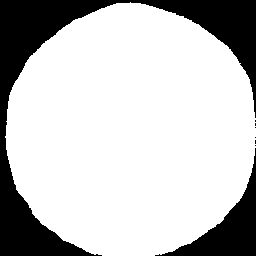
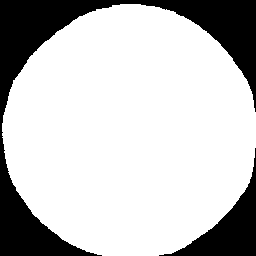
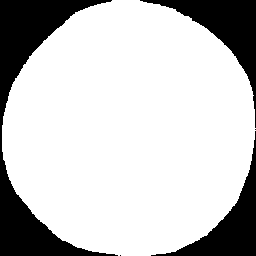

In [18]:
from vif.utils.detection_utils import get_segmentation_masks


colnodes = Image.open("notebooks/protos/images/node_removed.png")
colnode_seg,token_data = get_segmentation_masks(
    colnodes,
    gclient,
    ["node at the bottom left, under the red zone, not in it","node at the bottom of the blue zone","node in both the green and the blue zone"],
    visual_model,
)

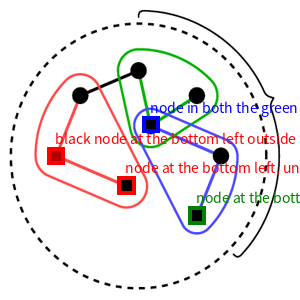

In [19]:
from vif.utils.detection_utils import plot_segmentation_masks


plot_segmentation_masks(colnodes,colnode_seg)

In [20]:
probs = [{"box":seg.box_prob,"seg":seg.seg_prob,"label":seg.label} for seg in colnode_seg]

In [21]:
probs

[{'box': 0.5776282630431114,
  'seg': 0.27374704771837266,
  'label': 'node at the bottom left, under the red zone, not in it'},
 {'box': 0.7181780572624756,
  'seg': 0.4071365331538358,
  'label': 'node at the bottom of the blue zone'},
 {'box': 0.6514579795666411,
  'seg': 0.3275383754745483,
  'label': 'node in both the green and the blue zone'}]